In [83]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray import air
from ray.tune import CLIReporter
from ray.tune import Tuner
from ray.tune.schedulers import HyperBandScheduler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures

In [84]:
df = pd.read_csv('train.csv')
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [85]:
df['Calories'] = np.log1p(df['Calories'])

In [86]:
df['Body_Ratio'] = df['Weight'] / df['Height']
df['Body_Expenditure'] = df['Body_Ratio'] * df['Heart_Rate']
df['Difficulty'] = df['Heart_Rate'] / df['Age']
df['Temp_Dist'] = df['Body_Temp'] / df['Body_Ratio']
df['Impact'] = df['Duration'] * df['Heart_Rate']
df['Impact_Temp'] = df['Duration'] * df['Body_Temp']

<Axes: xlabel='Age', ylabel='Calories'>

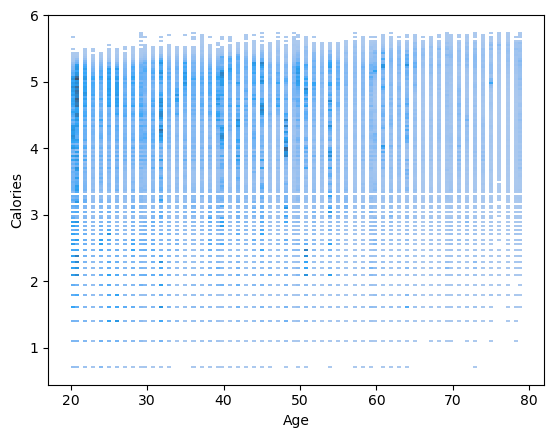

In [87]:
sns.histplot(df, x='Age', y='Calories')

In [88]:
bins = [18, 40, float('inf')]
labels = ['18_40', '40_plus']

In [89]:
df['Sex'] = np.where(df['Sex'] == 'male', 'men', 'women')
df['Age_Group'] = df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

In [90]:
df['Age_Group'].value_counts()

Age_Group
18_40      388368
40_plus    361632
Name: count, dtype: int64

In [91]:
genres = ['men', 'women']
dfdict = defaultdict(lambda: defaultdict(tuple))
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit(df.drop(columns=['id', 'Calories', 'Sex', 'Age_Group']))

for genre in genres:
    for age_group in labels:
        subset = df[(df['Sex'] == genre) & (df['Age_Group'] == age_group)]

        if subset.empty:
            print(age_group, genre)
            continue

        X = subset.drop(columns=['id', 'Calories', 'Sex', 'Age_Group'])
        X = pd.DataFrame(poly.transform(X))
        y = subset['Calories']
        dfdict[genre][age_group] = (X, y)

In [92]:
data = {
    'dfdict': dfdict
}

datasets = ray.put(data)

In [93]:
def makeXGB(config):
    data = ray.get(datasets)['dfdict']

    X, y = data[config['Sex']][config['Age_Group']]

    config.pop('Sex', None)
    config.pop('Age_Group', None)

    def safe_msle(y_true, y_pred):
        y_pred_clipped = np.maximum(0, y_pred) 
        return mean_squared_log_error(y_true, y_pred_clipped)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**config)
        model.fit(X_tr, y_tr)

        preds_val = model.predict(X_val)
        score = safe_msle(np.expm1(y_val), np.expm1(preds_val))
        fold_scores.append(score)

    mean_score = np.mean(fold_scores)

    ray.train.report(metrics={
        'neg_mean_squared_log_error': -mean_score
    })

In [94]:
config = {
    'max_depth': tune.randint(1, 500),
    'max_leaves': tune.randint(2, 500),
    'learning_rate': tune.uniform(0.001, 0.5),
    'n_estimators': tune.randint(50, 300),
    'eta': tune.loguniform(1e-5, 0.1),
    'subsample': tune.uniform(0.5, 1.0),
    'colsample_bytree': tune.uniform(0.5, 1.0),
    'gamma': tune.uniform(0, 10),
    'min_child_weight': tune.randint(5, 30),
    'lambda': tune.loguniform(1e-8, 1e-2),
    'alpha': tune.loguniform(1e-4, 10),
}

In [95]:
models = {}

for genre in genres:
    models[genre] = {}

    for age_group in labels:

        config['Sex'] = genre
        config['Age_Group'] = age_group

        reporter = CLIReporter(metric='neg_mean_squared_log_error', mode='max')
        hyperband = HyperBandScheduler(metric='neg_mean_squared_log_error', mode='max')

        tuner = Tuner(
            tune.with_resources(makeXGB, resources={"gpu": 1}),
            param_space=config,
            tune_config=tune.TuneConfig(num_samples=10, scheduler=hyperband),
            run_config=air.RunConfig(progress_reporter=reporter)
        )

        analysis = tuner.fit()
        best = analysis.get_best_result(metric='neg_mean_squared_log_error', mode='max').config

        best.update({
            'eval_metric': 'rmse',
            'random_state': 47,
            'n_estimators': 10000,
            'early_stopping_rounds': 5
        })
        best.pop('Sex', None)
        best.pop('Age_Group', None)

        X_raw, y_raw = dfdict[genre][age_group]
        X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.2, random_state=47)

        endmodel = XGBRegressor(**best)
        endmodel.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        models[genre][age_group] = endmodel

2025-05-25 19:09:19,361	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-25 19:09:19 (running for 00:00:00.14)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-09-19/makeXGB_2025-05-25_19-09-19/driver_artifacts
Number of trials: 5/5 (5 PENDING)


== Status ==
Current time: 2025-05-25 19:09:24 (running for 00:00:05.22)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-09-19/makeXGB_2025-05-25_19-09-19/driver_artifacts
Number of trials: 5/5 (4 PENDING, 1 RUNNING)


== Status ==
Current time: 2025-05-25 19:09:29 (running for 0

2025-05-25 19:18:24,747	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-25_19-09-19' in 0.0018s.
2025-05-25 19:18:24,749	INFO tune.py:1041 -- Total run time: 545.39 seconds (545.38 seconds for the tuning loop).


== Status ==
Current time: 2025-05-25 19:18:24 (running for 00:09:05.38)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: e7c25_00003 with neg_mean_squared_log_error=-0.00609210744943912 and parameters={'max_depth': 79, 'max_leaves': 436, 'learning_rate': 0.07944159774633464, 'n_estimators': 237, 'eta': 6.724797742796589e-05, 'subsample': 0.8844856943516284, 'colsample_bytree': 0.7457992012839478, 'gamma': 2.3191622837221484, 'min_child_weight': 9, 'lambda': 0.004654240199021538, 'alpha': 0.01671293606533199}
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-09-19/makeXGB_2025-05-25_19-09-19/driver_artifacts
Number of trials: 5/5 (5 TERMINATED)


[0]	validation_0-rmse:0.94485
[1]	validation_0-rmse:0.87054
[2]	validation_0-rmse:0.80217
[3]	validation_0-rmse:0.73928
[

2025-05-25 19:18:37,391	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-25 19:18:37 (running for 00:00:00.14)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-18-37/makeXGB_2025-05-25_19-18-37/driver_artifacts
Number of trials: 5/5 (5 PENDING)


== Status ==
Current time: 2025-05-25 19:18:42 (running for 00:00:05.21)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-18-37/makeXGB_2025-05-25_19-18-37/driver_artifacts
Number of trials: 5/5 (4 PENDING, 1 RUNNING)


== Status ==
Current time: 2025-05-25 19:18:47 (running for 0

2025-05-25 19:29:41,759	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-25_19-18-37' in 0.0022s.
2025-05-25 19:29:41,762	INFO tune.py:1041 -- Total run time: 664.37 seconds (664.36 seconds for the tuning loop).


== Status ==
Current time: 2025-05-25 19:29:41 (running for 00:11:04.36)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 345ee_00001 with neg_mean_squared_log_error=-0.003967680696872574 and parameters={'max_depth': 182, 'max_leaves': 83, 'learning_rate': 0.1426633471242203, 'n_estimators': 92, 'eta': 0.00012452683114554282, 'subsample': 0.8209207150644087, 'colsample_bytree': 0.910799919645797, 'gamma': 1.166309314802122, 'min_child_weight': 28, 'lambda': 1.2474525589859937e-05, 'alpha': 0.01932467842215322}
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-18-37/makeXGB_2025-05-25_19-18-37/driver_artifacts
Number of trials: 5/5 (5 TERMINATED)


[0]	validation_0-rmse:0.84456
[1]	validation_0-rmse:0.72506
[2]	validation_0-rmse:0.62269
[3]	validation_0-rmse:0.53510


2025-05-25 19:29:48,680	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-25 19:29:48 (running for 00:00:00.14)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-29-48/makeXGB_2025-05-25_19-29-48/driver_artifacts
Number of trials: 5/5 (5 PENDING)


== Status ==
Current time: 2025-05-25 19:29:53 (running for 00:00:05.18)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-29-48/makeXGB_2025-05-25_19-29-48/driver_artifacts
Number of trials: 5/5 (4 PENDING, 1 RUNNING)


== Status ==
Current time: 2025-05-25 19:29:58 (running for 0

2025-05-25 19:38:12,579	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-25_19-29-48' in 0.0021s.
2025-05-25 19:38:12,581	INFO tune.py:1041 -- Total run time: 503.90 seconds (503.89 seconds for the tuning loop).


== Status ==
Current time: 2025-05-25 19:38:12 (running for 00:08:23.89)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: c47d8_00001 with neg_mean_squared_log_error=-0.003115317197279457 and parameters={'max_depth': 130, 'max_leaves': 58, 'learning_rate': 0.12373161180549032, 'n_estimators': 72, 'eta': 0.0027391018044501934, 'subsample': 0.7815811252664213, 'colsample_bytree': 0.7635296549033843, 'gamma': 0.6970589382246994, 'min_child_weight': 13, 'lambda': 0.0028099425138166196, 'alpha': 0.23238850466159988}
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-29-48/makeXGB_2025-05-25_19-29-48/driver_artifacts
Number of trials: 5/5 (5 TERMINATED)


[0]	validation_0-rmse:0.82292
[1]	validation_0-rmse:0.72180
[2]	validation_0-rmse:0.63323
[3]	validation_0-rmse:0.55567

2025-05-25 19:38:20,593	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-25 19:38:20 (running for 00:00:00.14)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-38-20/makeXGB_2025-05-25_19-38-20/driver_artifacts
Number of trials: 5/5 (5 PENDING)


== Status ==
Current time: 2025-05-25 19:38:25 (running for 00:00:05.16)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-38-20/makeXGB_2025-05-25_19-38-20/driver_artifacts
Number of trials: 5/5 (4 PENDING, 1 RUNNING)


== Status ==
Current time: 2025-05-25 19:38:30 (running for 0

2025-05-25 19:47:57,507	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-25_19-38-20' in 0.0020s.
2025-05-25 19:47:57,509	INFO tune.py:1041 -- Total run time: 576.92 seconds (576.91 seconds for the tuning loop).


== Status ==
Current time: 2025-05-25 19:47:57 (running for 00:09:36.91)
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: f59d2_00001 with neg_mean_squared_log_error=-0.002037291775486027 and parameters={'max_depth': 121, 'max_leaves': 96, 'learning_rate': 0.177338200882828, 'n_estimators': 237, 'eta': 7.75464826956341e-05, 'subsample': 0.8574003658173419, 'colsample_bytree': 0.6575915919524129, 'gamma': 2.8525816975737364, 'min_child_weight': 20, 'lambda': 3.273480423810541e-08, 'alpha': 0.028639243117939736}
Result logdir: /tmp/ray/session_2025-05-25_12-03-37_644628_144543/artifacts/2025-05-25_19-38-20/makeXGB_2025-05-25_19-38-20/driver_artifacts
Number of trials: 5/5 (5 TERMINATED)


[0]	validation_0-rmse:0.71205
[1]	validation_0-rmse:0.58663
[2]	validation_0-rmse:0.48365
[3]	validation_0-rmse:0.39905


In [96]:
test = pd.read_csv('test.csv')

In [97]:
test

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5
...,...,...,...,...,...,...,...,...
249995,999995,female,56,159.0,62.0,6.0,85.0,39.4
249996,999996,male,32,202.0,101.0,3.0,84.0,38.4
249997,999997,female,31,164.0,64.0,14.0,98.0,40.1
249998,999998,female,62,158.0,61.0,25.0,106.0,40.7


In [98]:
test['Body_Ratio'] = test['Weight'] / test['Height']
test['Body_Expenditure'] = test['Body_Ratio'] * test['Heart_Rate']
test['Difficulty'] = test['Heart_Rate'] / test['Age']
test['Temp_Dist'] = test['Body_Temp'] / test['Body_Ratio']
test['Impact'] = test['Duration'] * test['Heart_Rate']
test['Impact_Temp'] = test['Duration'] * test['Body_Temp']


In [99]:
test['Sex'] = np.where(test['Sex'] == 'male', 'men', 'women')
test['Age_Group'] = pd.cut(test['Age'], bins=bins, labels=labels, right=True)

In [100]:
test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Body_Ratio,Body_Expenditure,Difficulty,Temp_Dist,Impact,Impact_Temp,Age_Group
0,750000,men,45,177.0,81.0,7.0,87.0,39.8,0.457627,39.813559,1.933333,86.970370,609.0,278.6,40_plus
1,750001,men,26,200.0,97.0,20.0,101.0,40.5,0.485000,48.985000,3.884615,83.505155,2020.0,810.0,18_40
2,750002,women,29,188.0,85.0,16.0,102.0,40.4,0.452128,46.117021,3.517241,89.355294,1632.0,646.4,18_40
3,750003,women,39,172.0,73.0,20.0,107.0,40.6,0.424419,45.412791,2.743590,95.660274,2140.0,812.0,18_40
4,750004,women,30,173.0,67.0,16.0,94.0,40.5,0.387283,36.404624,3.133333,104.574627,1504.0,648.0,18_40


In [101]:
testf = pd.DataFrame()

for genre in genres:
    for age_group in labels:
        subset = test[(test['Sex'] == genre) & (test['Age_Group'] == age_group)]
        ids = subset['id'].reset_index(drop=True)
        subset = subset.drop(columns=['id', 'Sex', 'Age_Group'])
        subset = pd.DataFrame(poly.transform(subset))
        subset = subset.reset_index(drop=True)
        subset['Calories'] = np.expm1(models[genre][age_group].predict(subset))
        subset['id'] = ids
        testf = pd.concat([testf, subset])

In [102]:
test = testf[['id', 'Calories']]

In [103]:
test

,id,Calories
0,750001,105.272705
1,750008,9.769536
2,750009,204.961884
3,750010,76.897316
4,750017,158.676239
...,...,...
59280,999981,9.072837
59281,999983,61.551586
59282,999988,117.726166
59283,999995,25.795712


In [104]:
test.to_csv('submission.csv', index=False)